In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import torch

In [8]:
with open('../data/dil_sim_test/errors_positions.pkl', 'rb') as f:
    pos = pickle.load(f)

In [12]:
pos[7][-1][1] - pos[7][-1][0]

46

In [56]:
n = 30 # num of series 
T = 20000 # len of series

In [57]:
data = np.zeros((n,T))
data_params = np.zeros((n,3))
for series in range(n):
    t0 = np.random.randint(50,101)
    w = np.random.randint(40,51) 
    scale = 0.3
    ran_seed = np.random.randint(0,2)
    tfun = np.sin if ran_seed else np.cos
    data_params[series] = np.array([t0, w, ran_seed])
    for t in range(T):
        bias = np.random.randn()
        data[series, t] = tfun((t -t0)/w) + scale*bias

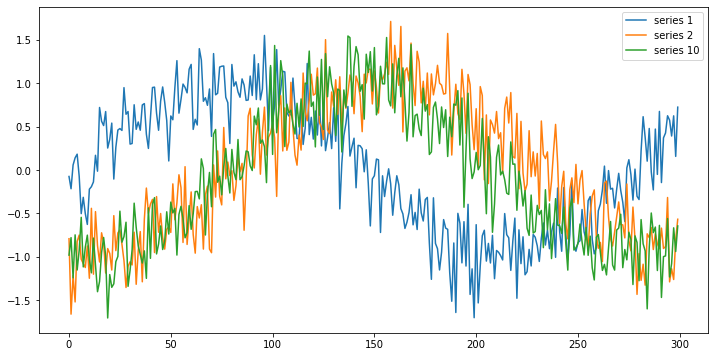

In [58]:
plt.figure(figsize=(12,6))
plt.plot(data[0, :300], label='series 1')
plt.plot(data[1, :300], label='series 2')
plt.plot(data[9, :300], label='series 10')
plt.legend()

In [59]:
errors_num = 4
errors = []
for i in range(errors_num):
    t0 = np.random.randint(50,101)
    w = np.random.randint(40,51) 
    scale = 0.3
    ran_seed = np.random.randint(0,2)
    tfun = np.sin if ran_seed else np.cos
    len_of_er = np.random.randint(30,91)
    
    err = []
    for t in range(len_of_er):
        bias = np.random.randn()
        err.append(tfun((t -t0)/w) + scale*bias)

    errors.append(err)

errors = np.array(errors, dtype=object)

In [60]:
n_er_inos = 3
ser_w_er = []
er_start = np.zeros(errors_num, dtype=int)
er_end = np.zeros(errors_num, dtype=int)

for i, error in enumerate(errors):
    er_start[i] = np.random.randint(10001, T-90)
    er_end[i] = er_start[i] + len(error)

er_sort_ind = np.argsort(er_start)
er_start = er_start[er_sort_ind]
er_end = er_end[er_sort_ind]
errors = errors[er_sort_ind]

for er_i in range(n_er_inos):
    ser_num = np.random.randint(0,n)
    while ser_num in ser_w_er:
        ser_num = np.random.randint(0,n)
    ser_w_er.append(ser_num)

In [61]:
ser_w_er

[7, 29, 16]

In [14]:
ar = np.array([0]*46)
ar[::16] = 1
ar

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [62]:
data_w_er = np.copy(data)
er_pos = dict()
dil = [2,4,8,16]
for i in range(n_er_inos):
    for j in range(errors_num):
        data_w_er[ser_w_er[i], er_start[j]:er_end[j]:dil[j]] = errors[j][::dil[j]]
        if ser_w_er[i] in er_pos:
            er_pos[ser_w_er[i]].append([er_start[j], er_end[j]])
        else:
            er_pos[ser_w_er[i]] = [[er_start[j], er_end[j]]]
 

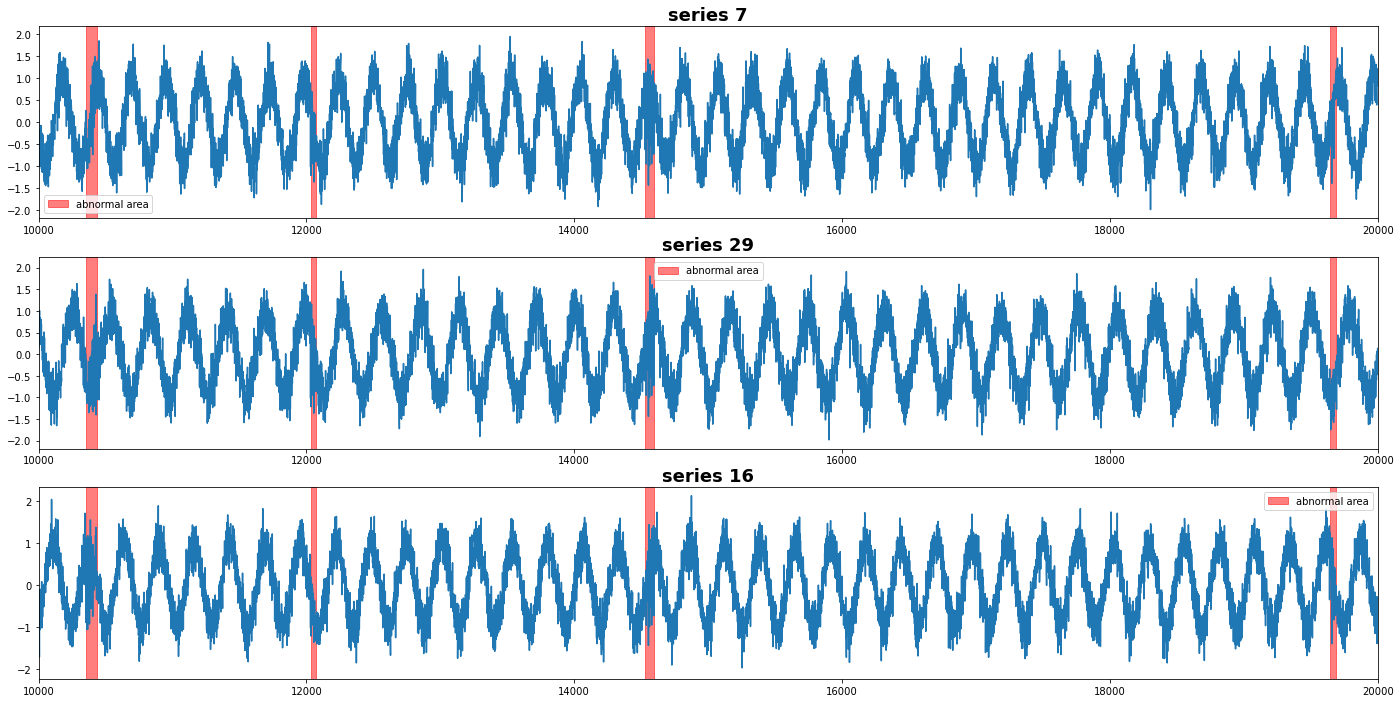

In [63]:
fig = plt.figure(figsize=(24,12))

# test_np_ct = test_np[:, :99*STRIDE+WIN_SIZE]
test_np_ct = data_w_er
test_sec_size = test_np_ct.shape[1]

params = {  'color':'red',
            'alpha':0.5 }

for i, ser in enumerate(er_pos):
    ax = fig.add_subplot(311+i)
    ax.plot(test_np_ct[ser])
    ax.set_title('series {}'.format(ser), weight='bold', size=18)

    is_first = True
    for er_start, er_end in er_pos[ser]:
        if is_first:
            ax.axvspan(er_start, er_end, label='abnormal area', **params)
            is_first=False
        else: 
            ax.axvspan(er_start, er_end, **params)

    ax.legend()
    ax.set_xlim([10000, 20000])


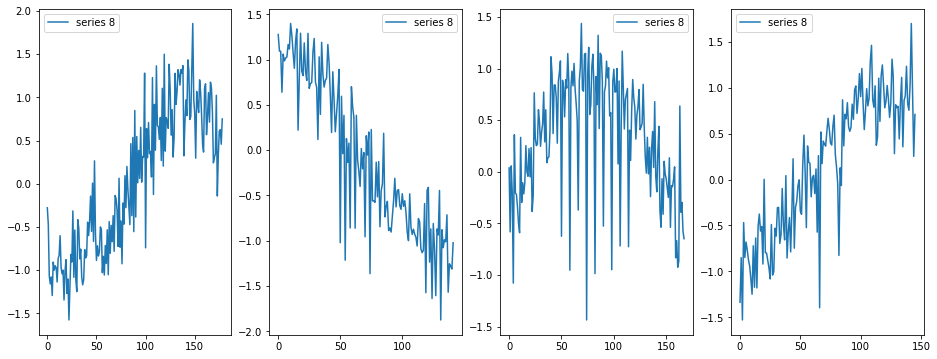

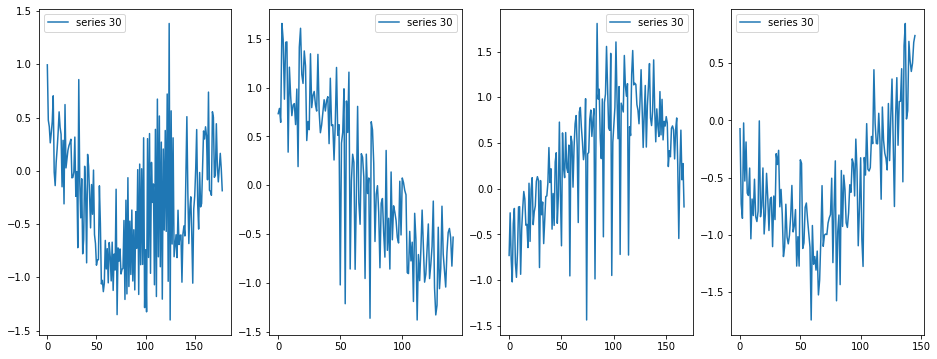

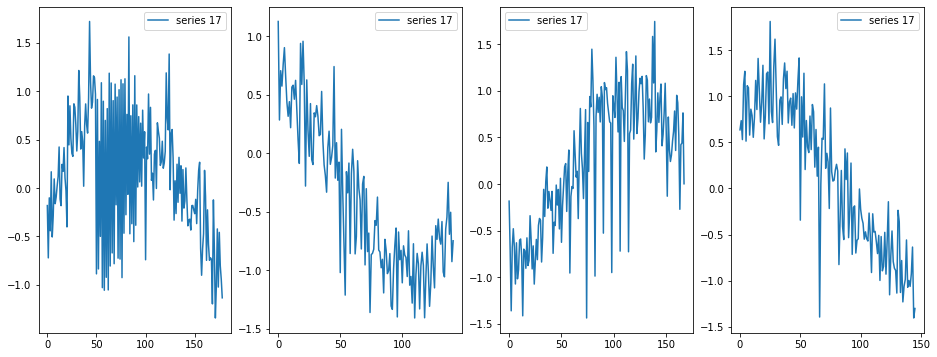

In [64]:
for i in range(3):
    fig = plt.figure(figsize=(20,6))
    counter = 0
    ser = er_pos.keys()
    ser = list(ser)[i]

    for er_start, er_end in er_pos[ser]:
        ax = fig.add_subplot(151+counter)
        counter+=1
        ax.plot(test_np_ct[ser, er_start-50:er_end+50],  label='series {}'.format(ser+1))
        plt.legend() 

In [65]:
full_data = torch.FloatTensor(data_w_er)

In [66]:
full_data.shape

torch.Size([30, 20000])

In [67]:
train = full_data[:, :8001]
valid = full_data[:, 8001:10001]
test = full_data[:, 10001:]

In [68]:
len(train[:,0])

30

In [69]:
PATH = 'dil_sim_test'
with open('../data/{}/train.pkl'.format(PATH), 'wb') as f:
    pickle.dump(train, f)
with open('../data/{}/valid.pkl'.format(PATH), 'wb') as f:
    pickle.dump(valid, f)
with open('../data/{}/test.pkl'.format(PATH), 'wb') as f:
    pickle.dump(test, f) 

In [70]:
er_pos_new = er_pos.copy()
for ser in er_pos:
    er_pos_new[ser] = np.array(er_pos_new[ser])
    for j in range(len(er_pos[ser])):
        er_pos_new[ser][j] -= train.shape[1] + valid.shape[1]
    print(er_pos_new[ser]) 

[[ 353  432]
 [2030 2072]
 [4529 4597]
 [9639 9685]]
[[ 353  432]
 [2030 2072]
 [4529 4597]
 [9639 9685]]
[[ 353  432]
 [2030 2072]
 [4529 4597]
 [9639 9685]]


In [71]:
with open('../data/{}/errors_positions.pkl'.format(PATH), 'wb') as f:
    pickle.dump(er_pos_new, f)